# Introduction

Ce dataset contient des données issues de 26000 parties classées "Challenger", 65000 parties "GrandMaster", et 100000 parties "Master" de League of Legends. Il présente des informations détaillées sur les deux équipes de chaque match : l’équipe bleue et l’équipe rouge.

L’objectif est d’identifier les facteurs déterminants dans la victoire ou la défaite d’une partie, et de développer une méthodologie pour prédire l’issue d’un match (victoire/défaite).

Variables importantes dans le dataset:

- ward : outils de vision (balises) pour éclairer la carte.
- gold : or utilisé pour acheter des objets.
- tower : nombre de tours détruites.
- inhibitors : nombre d'inhibiteurs détruits.
- dragon, baron : nombre de dragons et barons tués.
- minion : nombre de sbires tués.
- level : niveau moyen des champions (min : 1, max : 18).
Résultat : victoire ou défaite de l’équipe bleue (souvent la cible de la prédiction).

L'objectif sera de prédire si l'équipe bleue ou l'équipe rouge gagne une partie en fonction des paramètres du jeu. Le jeu de données inclut 3 niveaux de jeu différents ce qui permettra de réaliser une analyse croisée des modèles.

# Import des bibliothèques

In [2]:
!pip install shap
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
import xgboost as xgb

# Préparation des données

## Data loading

In [4]:
# 1. Télécharger le dataset
path = kagglehub.dataset_download("gyejr95/league-of-legends-challenger-ranked-games2020")

# 2. Charger chaque fichier dans une variable différente
challenger_df = pd.read_csv(os.path.join(path, "Challenger_Ranked_Games.csv"))
grandmaster_df = pd.read_csv(os.path.join(path, "GrandMaster_Ranked_Games.csv"))
master_df = pd.read_csv(os.path.join(path, "Master_Ranked_Games.csv"))

# 3. Aperçu rapide
print("Challenger:", challenger_df.shape)
print("GrandMaster:", grandmaster_df.shape)
print("Master:", master_df.shape)


Challenger: (26904, 50)
GrandMaster: (65896, 50)
Master: (107125, 50)


## Exploration

In [5]:
# Vérifier que les 3 datasets ont exactement les mêmes colonnes
if (
    list(challenger_df.columns) == list(grandmaster_df.columns) == list(master_df.columns)
):
    print("Les 3 datasets ont exactement les mêmes 50 colonnes (noms et ordre)")
else:
    print("Les colonnes des 3 datasets ne sont pas identiques")


Les 3 datasets ont exactement les mêmes 50 colonnes (noms et ordre)


In [6]:
dataframes = {
    "Challenger": challenger_df,
    "GrandMaster": grandmaster_df,
    "Master": master_df
}

for name, df in dataframes.items():
    total_missing = df.isnull().sum().sum()

    if total_missing == 0:
        print(f"Aucune valeur manquante dans le dataset {name}")
    else:
        print(f"{total_missing} valeurs manquantes détectées dans le dataset {name}")
        print("Colonnes concernées :")
        print(df.isnull().sum()[df.isnull().sum() > 0])
        print("-" * 50)


Aucune valeur manquante dans le dataset Challenger
Aucune valeur manquante dans le dataset GrandMaster
Aucune valeur manquante dans le dataset Master


In [7]:
print("Nom des colonnes et type de chaque colonne :")
print(df.dtypes)

Nom des colonnes et type de chaque colonne :
gameId                       int64
gameDuraton                  int64
blueWins                     int64
blueFirstBlood               int64
blueFirstTower               int64
blueFirstBaron               int64
blueFirstDragon              int64
blueFirstInhibitor           int64
blueDragonKills              int64
blueBaronKills               int64
blueTowerKills               int64
blueInhibitorKills           int64
blueWardPlaced               int64
blueWardkills                int64
blueKills                    int64
blueDeath                    int64
blueAssist                   int64
blueChampionDamageDealt      int64
blueTotalGold                int64
blueTotalMinionKills         int64
blueTotalLevel               int64
blueAvgLevel               float64
blueJungleMinionKills        int64
blueKillingSpree             int64
blueTotalHeal                int64
blueObjectDamageDealt        int64
redWins                      int64
redFirstBl

In [8]:
# Vérifier si les colonnes blueWins et redWins sont cohérentes
if all(df['redWins'] == (1 - df['blueWins'])):
    print("Les colonnes 'redWins' et 'blueWins' sont cohérentes.")
else:
    print("Les colonnes 'redWins' et 'blueWins' ne sont pas cohérentes.")


Les colonnes 'redWins' et 'blueWins' sont cohérentes.


redWins et blueWins sont liées et peuvent être utilisées de manière interchangeable dans le modèle

In [9]:
print(challenger_df.describe())

             gameId   gameDuraton      blueWins  blueFirstBlood  \
count  2.690400e+04  26904.000000  26904.000000    26904.000000   
mean   4.171927e+09   1448.653657      0.500074        0.503531   
std    7.479506e+07    422.577288      0.500009        0.499997   
min    3.482433e+09    190.000000      0.000000        0.000000   
25%    4.142427e+09   1152.000000      0.000000        0.000000   
50%    4.190657e+09   1435.000000      1.000000        1.000000   
75%    4.219650e+09   1738.000000      1.000000        1.000000   
max    4.261026e+09   3301.000000      1.000000        1.000000   

       blueFirstTower  blueFirstBaron  blueFirstDragon  blueFirstInhibitor  \
count    26904.000000    26904.000000     26904.000000        26904.000000   
mean         0.525610        0.244090         0.406334            0.367120   
std          0.499353        0.429554         0.491157            0.482029   
min          0.000000        0.000000         0.000000            0.000000   
25%   

In [10]:
print(grandmaster_df.describe())

             gameId   gameDuraton      blueWins  blueFirstBlood  \
count  6.589600e+04  65896.000000  65896.000000    65896.000000   
mean   4.172854e+09   1427.961591      0.495614        0.506966   
std    7.889291e+07    429.784566      0.499985        0.499955   
min    3.191955e+09    132.000000      0.000000        0.000000   
25%    4.144505e+09   1121.000000      0.000000        0.000000   
50%    4.194611e+09   1414.000000      0.000000        1.000000   
75%    4.224057e+09   1724.000000      1.000000        1.000000   
max    4.257022e+09   3301.000000      1.000000        1.000000   

       blueFirstTower  blueFirstBaron  blueFirstDragon  blueFirstInhibitor  \
count    65896.000000    65896.000000     65896.000000        65896.000000   
mean         0.515873        0.234400         0.395305            0.381192   
std          0.499752        0.423626         0.488920            0.485683   
min          0.000000        0.000000         0.000000            0.000000   
25%   

In [11]:
print(master_df.describe())

             gameId    gameDuraton       blueWins  blueFirstBlood  \
count  1.071250e+05  107125.000000  107125.000000   107125.000000   
mean   4.159074e+09    1432.977914       0.495132        0.507025   
std    1.029108e+08     436.506952       0.499979        0.499953   
min    3.163679e+09     190.000000       0.000000        0.000000   
25%    4.129344e+09    1121.000000       0.000000        0.000000   
50%    4.189629e+09    1420.000000       0.000000        1.000000   
75%    4.222893e+09    1735.000000       1.000000        1.000000   
max    4.257322e+09    3758.000000       1.000000        1.000000   

       blueFirstTower  blueFirstBaron  blueFirstDragon  blueFirstInhibitor  \
count   107125.000000   107125.000000    107125.000000       107125.000000   
mean         0.513410        0.236229         0.408047            0.387715   
std          0.499822        0.424766         0.491474            0.487231   
min          0.000000        0.000000         0.000000            

In [12]:
# Analyser la distribution des victoires (blueWins) pour chaque niveau
for name, df in dataframes.items():
    print(f"\nDistribution des victoires pour le dataset {name}:")
    print(df['blueWins'].value_counts())



Distribution des victoires pour le dataset Challenger:
blueWins
1    13454
0    13450
Name: count, dtype: int64

Distribution des victoires pour le dataset GrandMaster:
blueWins
0    33237
1    32659
Name: count, dtype: int64

Distribution des victoires pour le dataset Master:
blueWins
0    54084
1    53041
Name: count, dtype: int64


In [13]:
# Analyse des performances des équipes (bleue vs rouge)
print(df.groupby('blueWins')[['blueFirstBlood','blueFirstBlood','blueFirstBaron','blueFirstInhibitor',
                              'blueDragonKills', 'blueKills', 'blueDeath','blueTowerKills','blueInhibitorKills',
                              'blueWardPlaced','blueWardPlaced','blueWardkills','blueAssist','blueChampionDamageDealt',
                              'blueTotalGold','blueTotalMinionKills','blueJungleMinionKills','blueKillingSpree','blueObjectDamageDealt']].mean())

          blueFirstBlood  blueFirstBlood  blueFirstBaron  blueFirstInhibitor  \
blueWins                                                                       
0               0.403557        0.403557        0.080763            0.065195   
1               0.612526        0.612526        0.394751            0.716578   

          blueDragonKills  blueKills  blueDeath  blueTowerKills  \
blueWins                                                          
0                0.792471  19.198746  30.355706        1.909770   
1                1.937388  30.407741  19.030052        6.829076   

          blueInhibitorKills  blueWardPlaced  blueWardPlaced  blueWardkills  \
blueWins                                                                      
0                   0.127635       51.335682       51.335682      17.801494   
1                   1.192153       52.712072       52.712072      19.575460   

          blueAssist  blueChampionDamageDealt  blueTotalGold  \
blueWins                     

## Matrice de corrélation

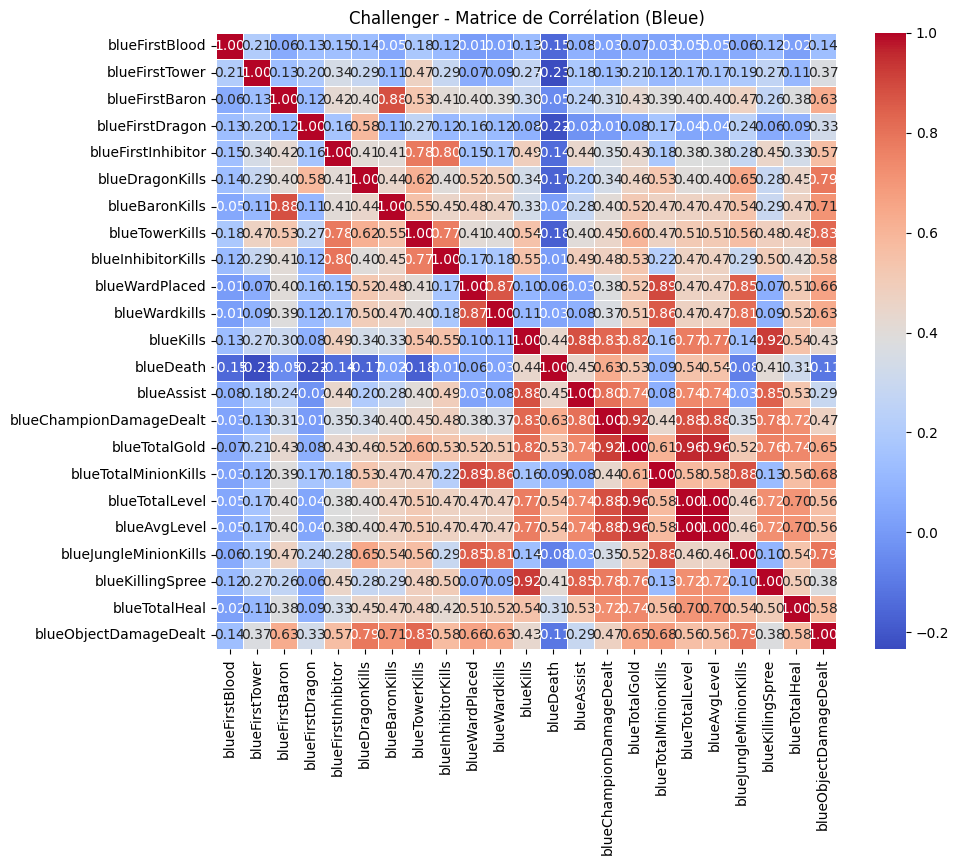

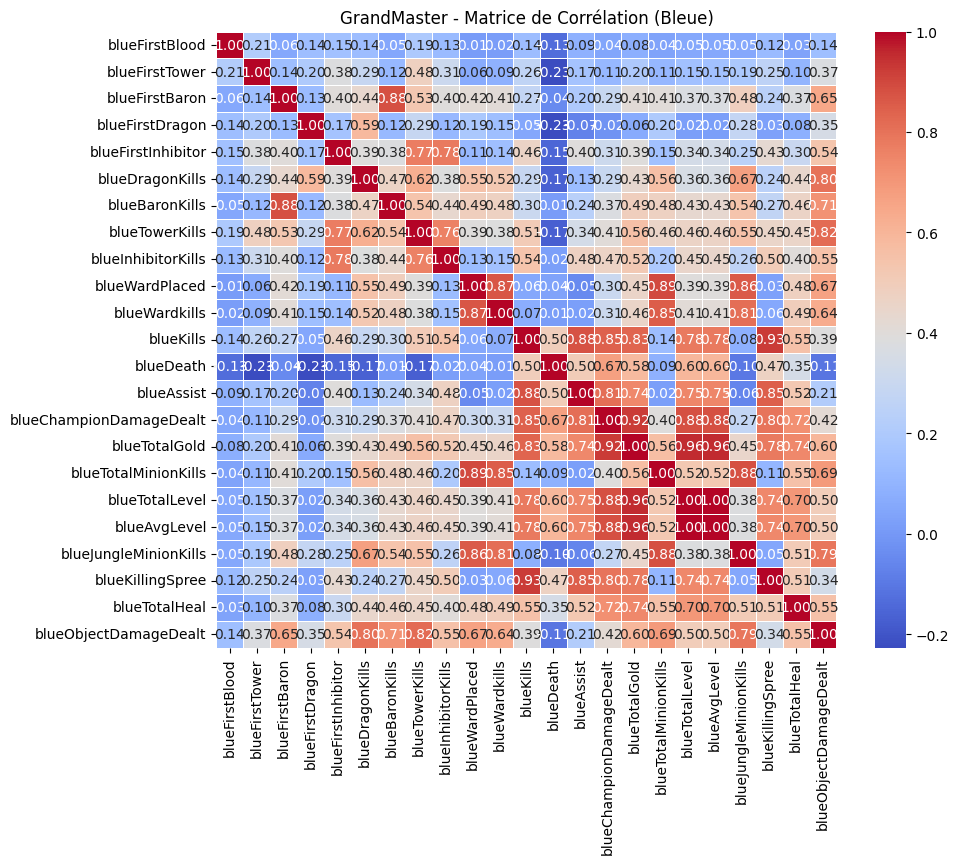

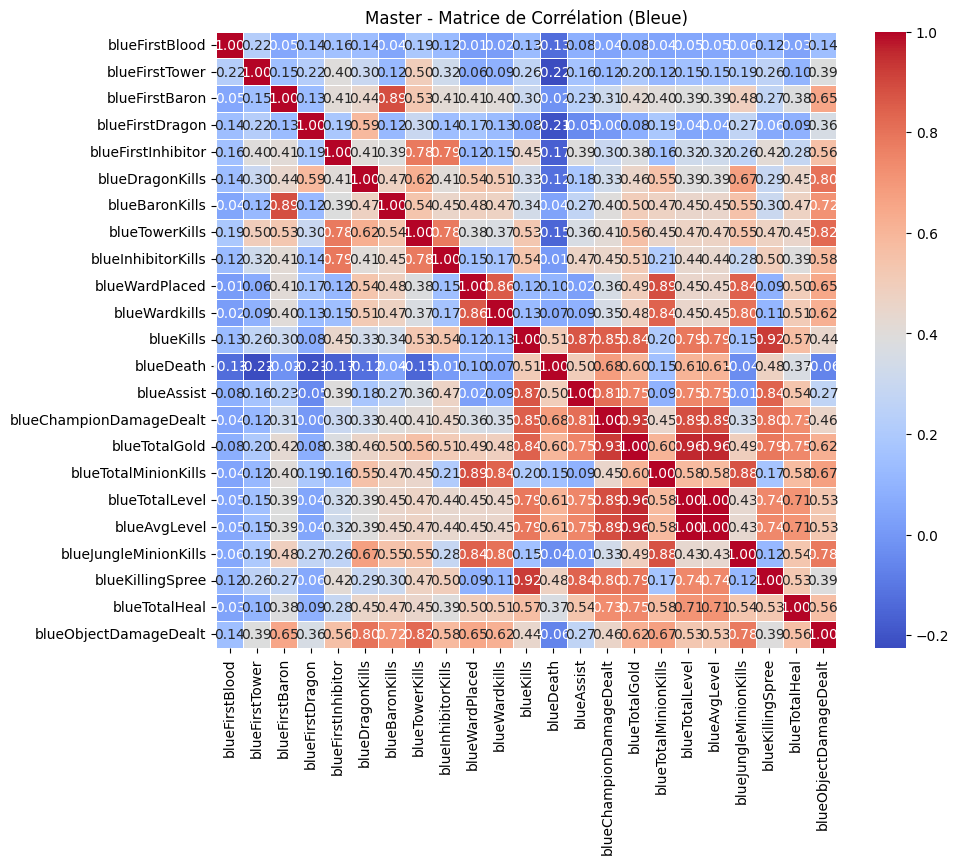

In [14]:
# Colonnes pour l'équipe bleue
blue_columns = [
    'blueFirstBlood', 'blueFirstTower', 'blueFirstBaron', 'blueFirstDragon',
    'blueFirstInhibitor', 'blueDragonKills', 'blueBaronKills', 'blueTowerKills',
    'blueInhibitorKills', 'blueWardPlaced', 'blueWardkills', 'blueKills',
    'blueDeath', 'blueAssist', 'blueChampionDamageDealt', 'blueTotalGold',
    'blueTotalMinionKills', 'blueTotalLevel', 'blueAvgLevel', 'blueJungleMinionKills',
    'blueKillingSpree', 'blueTotalHeal', 'blueObjectDamageDealt'
]

# Fonction pour afficher la matrice de corrélation pour un DataFrame donné
def plot_correlation_matrix(df, columns, title):
    corr_matrix = df[columns].corr()  # Calcul de la matrice de corrélation
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title)
    plt.show()

# Matrice de corrélation pour l'équipe bleue - Challenger
plot_correlation_matrix(challenger_df, blue_columns, 'Challenger - Matrice de Corrélation (Bleue)')

# Matrice de corrélation pour l'équipe bleue - GrandMaster
plot_correlation_matrix(grandmaster_df, blue_columns, 'GrandMaster - Matrice de Corrélation (Bleue)')

# Matrice de corrélation pour l'équipe bleue - Master
plot_correlation_matrix(master_df, blue_columns, 'Master - Matrice de Corrélation (Bleue)')


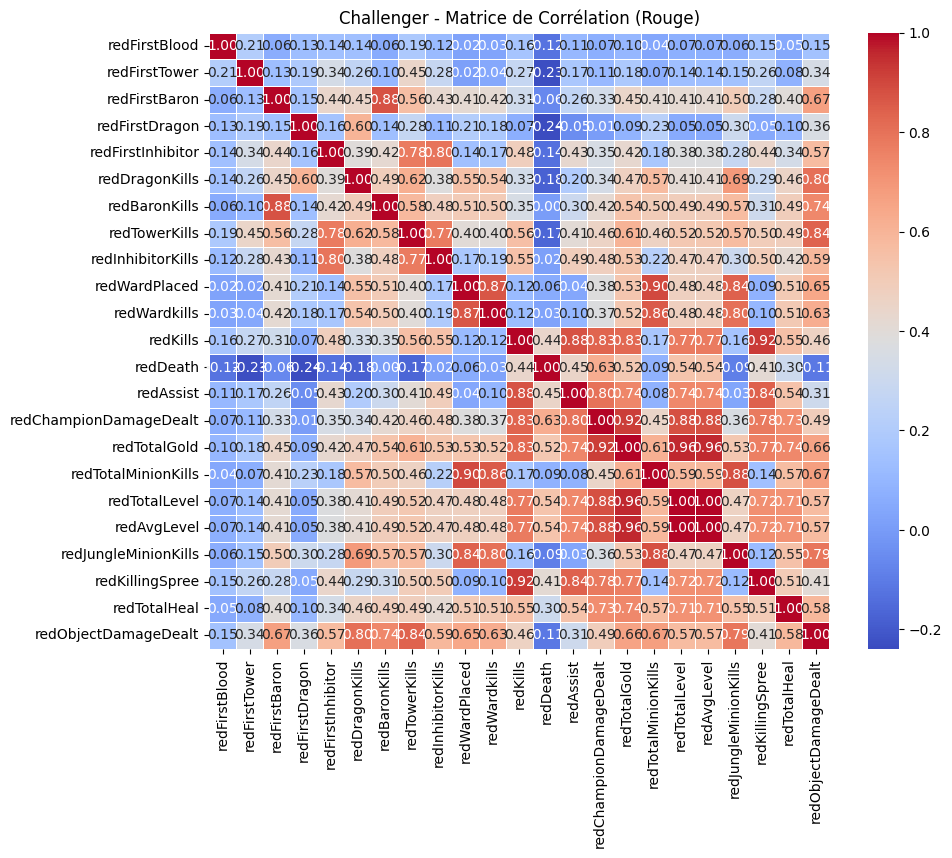

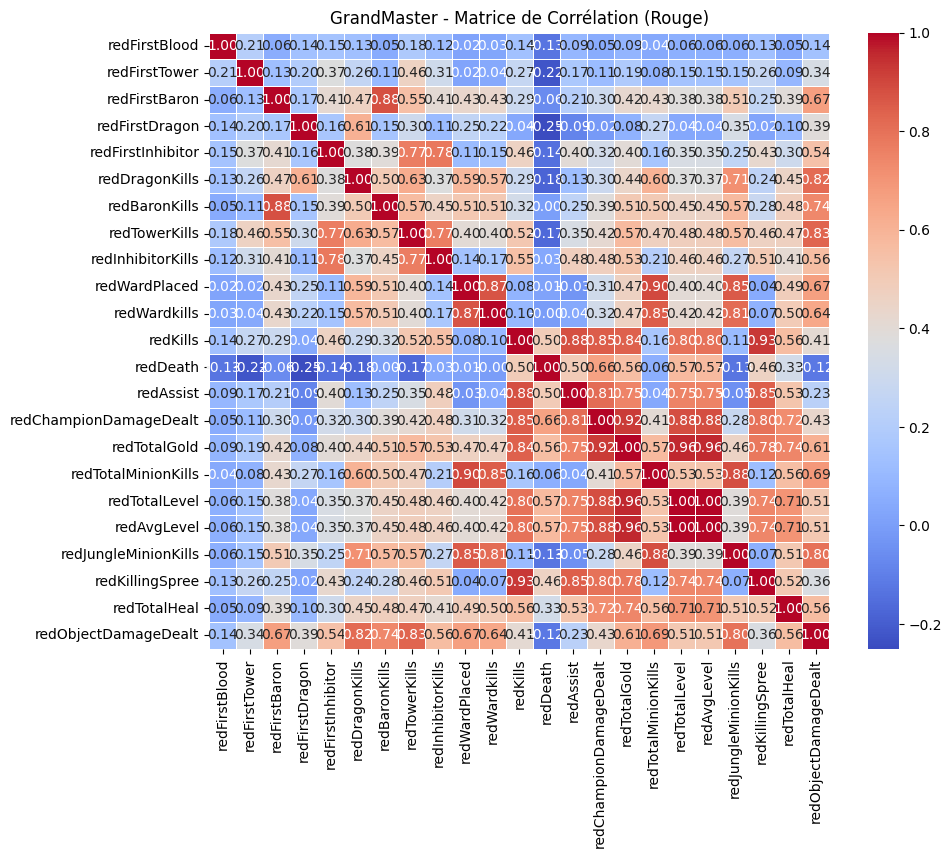

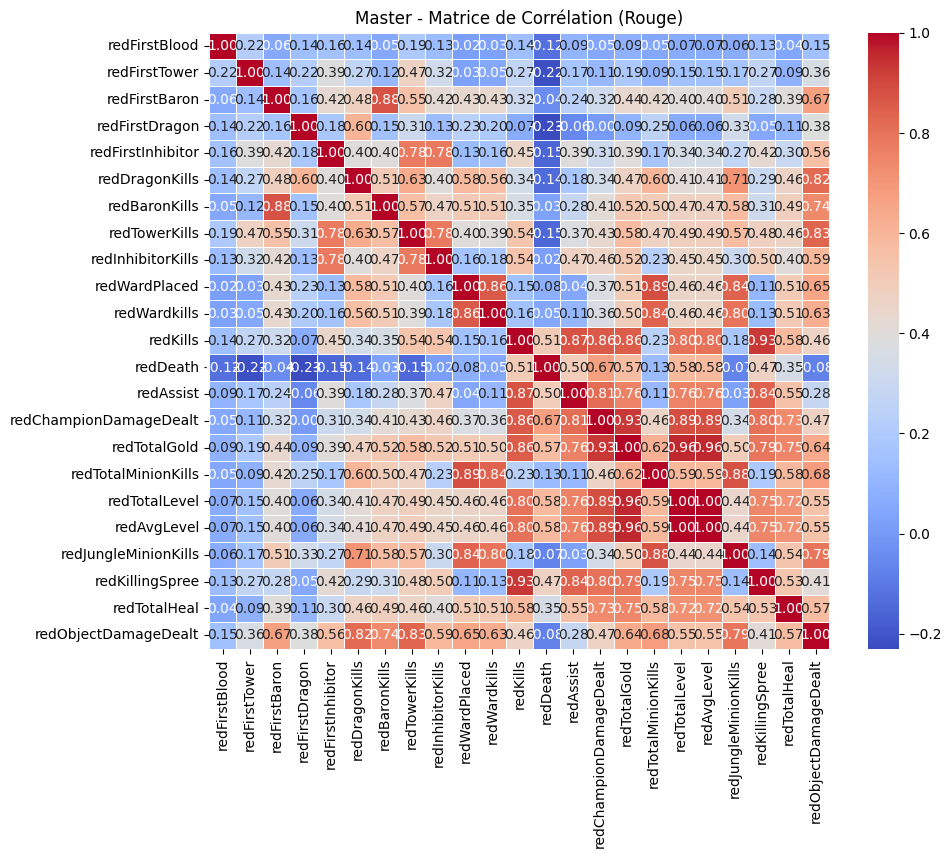

In [15]:
# Colonnes pour l'équipe rouge
red_columns = [
    'redFirstBlood', 'redFirstTower', 'redFirstBaron', 'redFirstDragon',
    'redFirstInhibitor', 'redDragonKills', 'redBaronKills', 'redTowerKills',
    'redInhibitorKills', 'redWardPlaced', 'redWardkills', 'redKills',
    'redDeath', 'redAssist', 'redChampionDamageDealt', 'redTotalGold',
    'redTotalMinionKills', 'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
    'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt'
]

# Matrice de corrélation pour l'équipe rouge - Challenger
plot_correlation_matrix(challenger_df, red_columns, 'Challenger - Matrice de Corrélation (Rouge)')

# Matrice de corrélation pour l'équipe rouge - GrandMaster
plot_correlation_matrix(grandmaster_df, red_columns, 'GrandMaster - Matrice de Corrélation (Rouge)')

# Matrice de corrélation pour l'équipe rouge - Master
plot_correlation_matrix(master_df, red_columns, 'Master - Matrice de Corrélation (Rouge)')


## Préparation des dataframes train-test pour les 3 niveaux de jeu

In [16]:
# Liste des colonnes associées à l'équipe bleue
blue_columns = [
    'blueFirstBlood', 'blueFirstTower', 'blueFirstBaron', 'blueFirstDragon',
    'blueFirstInhibitor', 'blueDragonKills', 'blueBaronKills', 'blueTowerKills',
    'blueInhibitorKills', 'blueWardPlaced', 'blueWardkills', 'blueKills',
    'blueDeath', 'blueAssist', 'blueChampionDamageDealt', 'blueTotalGold',
    'blueTotalMinionKills', 'blueTotalLevel', 'blueAvgLevel', 'blueJungleMinionKills',
    'blueKillingSpree', 'blueTotalHeal', 'blueObjectDamageDealt'
]

# Liste des colonnes à supprimer en raison de fortes corrélations
columns_to_drop = [
    'blueInhibitorKills',
    'blueJungleMinionKills',
    'blueAvgLevel',
    'blueWardkills',
    'blueBaronKills',
    'blueFirstInhibitor'
]

filtered_blue_columns = [col for col in blue_columns if col not in columns_to_drop]

# Fonction de préparation des données pour un modèle de régression (train-test split et normalisation)
def prepare_data_for_prediction(df, target_column='blueWins', blue_columns=None):
    """
    Prépare les données pour la prédiction en séparant la cible et les variables explicatives,
    et en normalisant les données.
    """

    X = df[blue_columns]
    y = df[target_column]

    # Diviser les données en ensemble d'entraînement et ensemble de test (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Mise à l'échelle des données (normalisation) pour les modèles
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Préparer les données pour chaque niveau (Challenger, GrandMaster, Master)

# Challenger
X_train_challenger, X_test_challenger, y_train_challenger, y_test_challenger = prepare_data_for_prediction(challenger_df, target_column='blueWins', blue_columns=filtered_blue_columns)

# GrandMaster
X_train_grandmaster, X_test_grandmaster, y_train_grandmaster, y_test_grandmaster = prepare_data_for_prediction(grandmaster_df, target_column='blueWins', blue_columns=filtered_blue_columns)

# Master
X_train_master, X_test_master, y_train_master, y_test_master = prepare_data_for_prediction(master_df, target_column='blueWins', blue_columns=filtered_blue_columns)

# Afficher les formes des ensembles de données pour vérifier
print(f"Challenger - X_train shape: {X_train_challenger.shape}, X_test shape: {X_test_challenger.shape}")
print(f"GrandMaster - X_train shape: {X_train_grandmaster.shape}, X_test shape: {X_test_grandmaster.shape}")
print(f"Master - X_train shape: {X_train_master.shape}, X_test shape: {X_test_master.shape}")

Challenger - X_train shape: (18832, 17), X_test shape: (8072, 17)
GrandMaster - X_train shape: (46127, 17), X_test shape: (19769, 17)
Master - X_train shape: (74987, 17), X_test shape: (32138, 17)


Installation des bibliothèques

# Modélisation par régression logistique

£ Résultats pour la ligue Challenger £
----------------------------------------
Précision : 0.9645
Recall : 0.9614
Score F1 : 0.9629
Accuracy : 0.9627

--- Matrice de Confusion ---


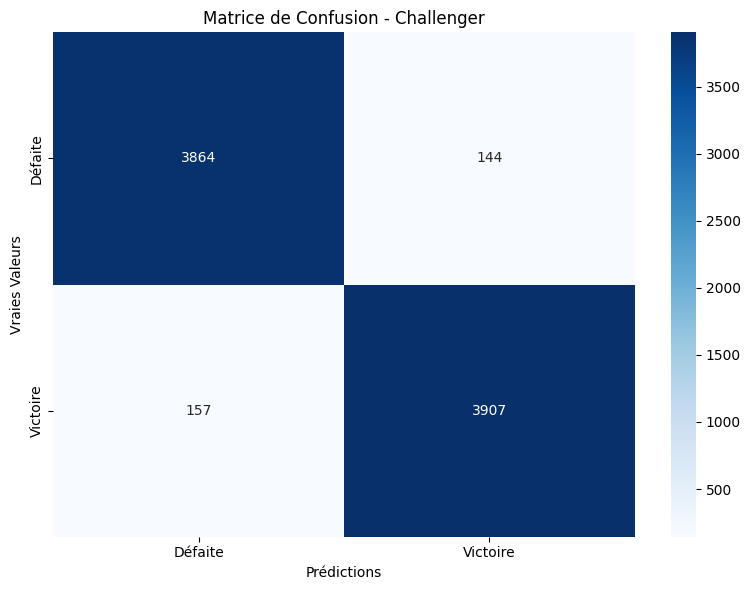


--- Top 5 Caractéristiques les Plus Importantes ---
                 Feature  Coefficient
8              blueDeath    -4.107656
5         blueTowerKills     3.067731
7              blueKills     2.575851
6         blueWardPlaced    -0.968123
12  blueTotalMinionKills    -0.541091
£ Résultats pour la ligue GrandMaster £
----------------------------------------
Précision : 0.9549
Recall : 0.9612
Score F1 : 0.9580
Accuracy : 0.9582

--- Matrice de Confusion ---


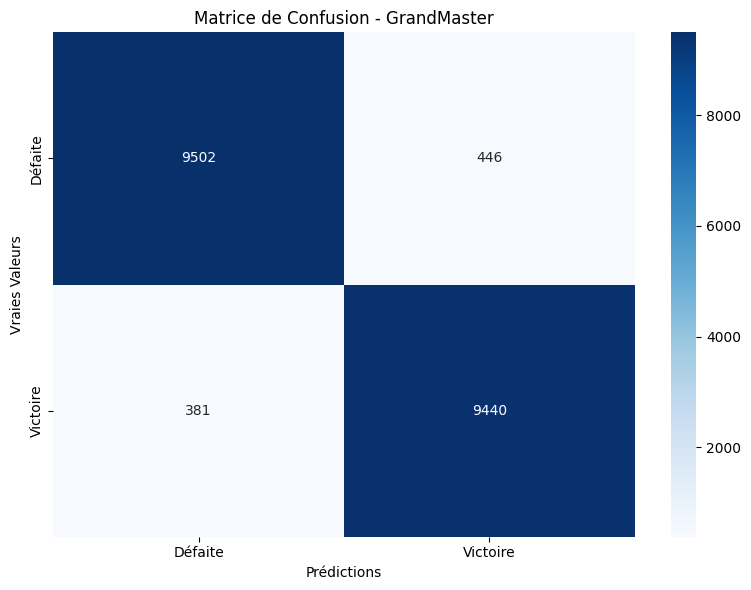


--- Top 5 Caractéristiques les Plus Importantes ---
          Feature  Coefficient
8       blueDeath    -4.284244
5  blueTowerKills     3.326285
7       blueKills     2.759718
6  blueWardPlaced    -0.949213
9      blueAssist     0.713945
£ Résultats pour la ligue Master £
----------------------------------------
Précision : 0.9576
Recall : 0.9573
Score F1 : 0.9574
Accuracy : 0.9581

--- Matrice de Confusion ---


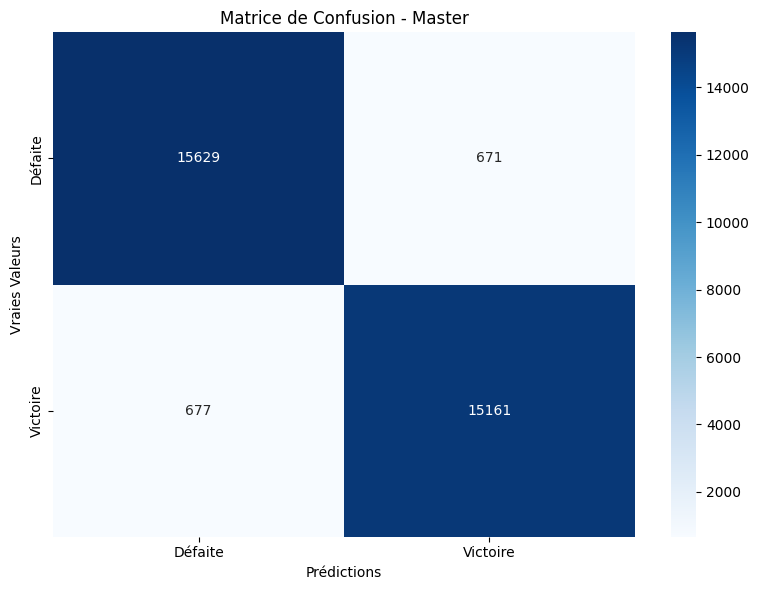


--- Top 5 Caractéristiques les Plus Importantes ---
          Feature  Coefficient
8       blueDeath    -4.337734
5  blueTowerKills     3.310852
7       blueKills     2.613980
6  blueWardPlaced    -0.893966
9      blueAssist     0.654475


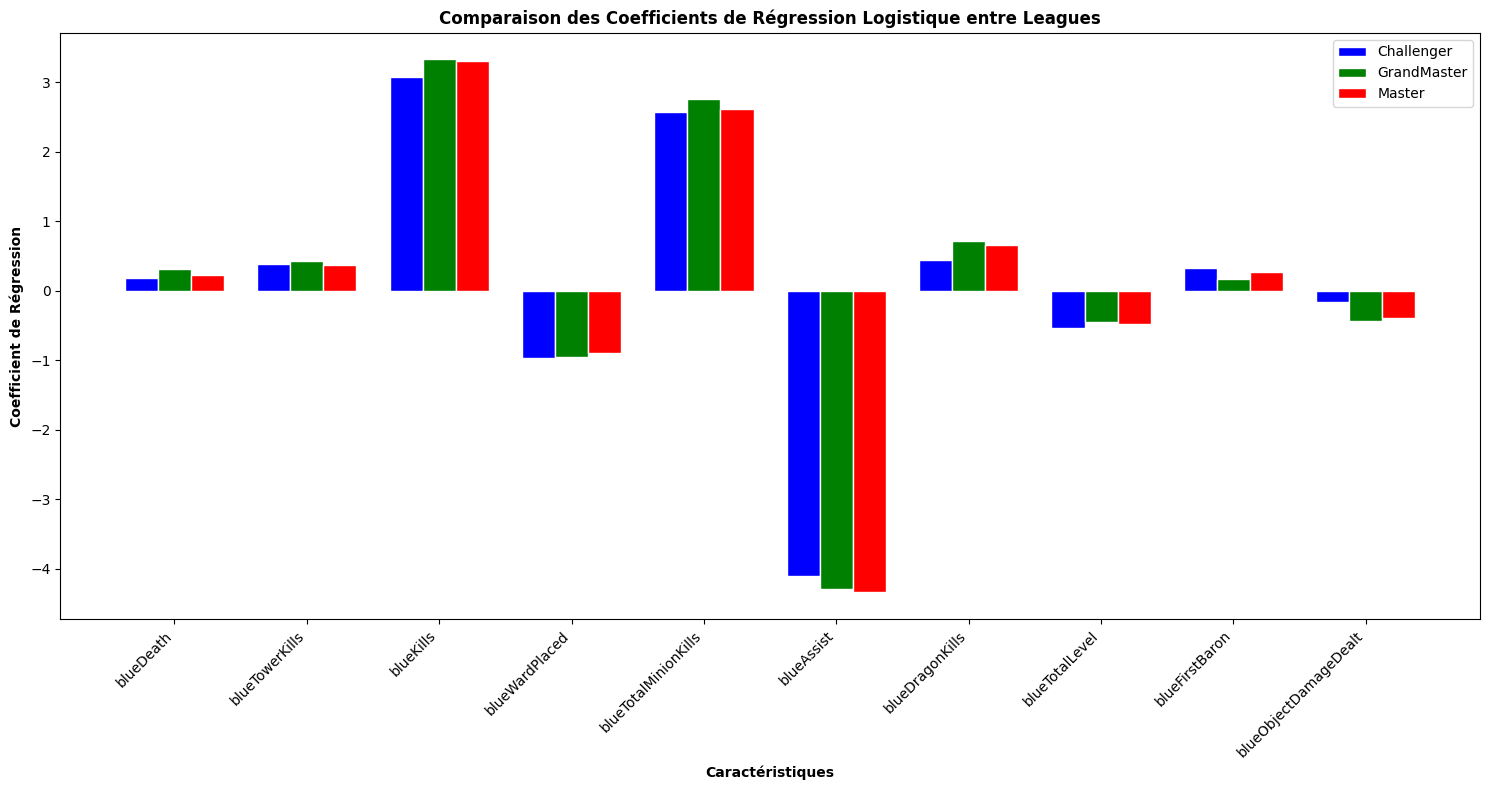

Rapport Comparatif de Régression Logistique

Métriques de Performance
Ligue        Accuracy   Précision  Recall     F1 Score  
----------------------------------------------------
Challenger   0.9627     0.9645     0.9614     0.9629    
GrandMaster  0.9582     0.9549     0.9612     0.9580    
Master       0.9581     0.9576     0.9573     0.9574    

Matrices de Confusion
Ligue        TN       FP       FN       TP      
--------------------------------------------
Challenger   3864     144      157      3907    
GrandMaster  9502     446      381      9440    
Master       15629    671      677      15161   

Top 5 Caractéristiques par Ligue

Challenger:
Caractéristique           Coefficient    
----------------------------------------
blueDeath                 -4.1077        
blueTowerKills            3.0677         
blueKills                 2.5759         
blueWardPlaced            -0.9681        
blueTotalMinionKills      -0.5411        

GrandMaster:
Caractéristique           Coeff

In [17]:
def perform_logistic_regression(X_train, X_test, y_train, y_test, league_name):

    # Initialiser et entraîner le modèle de régression logistique
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = lr_model.predict(X_test)

    # Calculer les métriques de performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Affichage des résultats
    print(f"£ Résultats pour la ligue {league_name} £")
    print("-" * 40)
    print(f"Précision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"Score F1 : {f1:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print("\n--- Matrice de Confusion ---")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Défaite', 'Victoire'],
                yticklabels=['Défaite', 'Victoire'])
    plt.title(f'Matrice de Confusion - {league_name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies Valeurs')
    plt.tight_layout()
    plt.show()

    # Coefficients du modèle
    coef_df = pd.DataFrame({
        'Feature': filtered_blue_columns,
        'Coefficient': lr_model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\n--- Top 5 Caractéristiques les Plus Importantes ---")
    print(coef_df.head())

    # Créer un dictionnaire de résultats pour le rapport
    results = {
        'League': league_name,
        'Metrics': {
            'Accuracy': f"{accuracy:.4f}",
            'Precision': f"{precision:.4f}",
            'Recall': f"{recall:.4f}",
            'F1 Score': f"{f1:.4f}"
        },
        'Confusion Matrix': {
            'True Negative': cm[0, 0],
            'False Positive': cm[0, 1],
            'False Negative': cm[1, 0],
            'True Positive': cm[1, 1]
        },
        'Top Features': coef_df.head()
    }

    return lr_model, results

# Effectuer la régression logistique pour chaque ligue
lr_challenger, results_challenger = perform_logistic_regression(
    X_train_challenger, X_test_challenger,
    y_train_challenger, y_test_challenger,
    "Challenger"
)

lr_grandmaster, results_grandmaster = perform_logistic_regression(
    X_train_grandmaster, X_test_grandmaster,
    y_train_grandmaster, y_test_grandmaster,
    "GrandMaster"
)

lr_master, results_master = perform_logistic_regression(
    X_train_master, X_test_master,
    y_train_master, y_test_master,
    "Master"
)


def compare_coefficients(lr_challenger, lr_grandmaster, lr_master):

    # Créer des DataFrames pour chaque ligue
    challenger_coef = pd.DataFrame({
        'Feature': filtered_blue_columns,
        'Coefficient': lr_challenger.coef_[0]
    })

    grandmaster_coef = pd.DataFrame({
        'Feature': filtered_blue_columns,
        'Coefficient': lr_grandmaster.coef_[0]
    })

    master_coef = pd.DataFrame({
        'Feature': filtered_blue_columns,
        'Coefficient': lr_master.coef_[0]
    })

    # Trier les caractéristiques par valeur absolue des coefficients
    top_features = challenger_coef.reindex(
        challenger_coef['Coefficient'].abs().sort_values(ascending=False).index
    )

    # Sélectionner les 10 caractéristiques les plus importantes
    top_10_features = top_features['Feature'][:10]

    # Préparer les données pour le graphique
    challenger_top = challenger_coef[challenger_coef['Feature'].isin(top_10_features)]
    grandmaster_top = grandmaster_coef[grandmaster_coef['Feature'].isin(top_10_features)]
    master_top = master_coef[master_coef['Feature'].isin(top_10_features)]

    # Configurer le graphique
    plt.figure(figsize=(15, 8))
    bar_width = 0.25

    # Positions des barres
    r1 = np.arange(len(top_10_features))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Créer les barres
    plt.bar(r1, challenger_top['Coefficient'], color='blue', width=bar_width, edgecolor='white', label='Challenger')
    plt.bar(r2, grandmaster_top['Coefficient'], color='green', width=bar_width, edgecolor='white', label='GrandMaster')
    plt.bar(r3, master_top['Coefficient'], color='red', width=bar_width, edgecolor='white', label='Master')

    # Personnaliser le graphique
    plt.xlabel('Caractéristiques', fontweight='bold')
    plt.ylabel('Coefficient de Régression', fontweight='bold')
    plt.title('Comparaison des Coefficients de Régression Logistique entre Leagues', fontweight='bold')


    plt.xticks([r + bar_width for r in range(len(top_10_features))], top_10_features, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

# Appeler la fonction de comparaison des coefficients
compare_coefficients(lr_challenger, lr_grandmaster, lr_master)



def generate_plain_text_report(results_list):

    print("Rapport Comparatif de Régression Logistique")
    print("=" * 50)

    # Préparer un format de tableau pour les métriques
    print("\nMétriques de Performance")
    print("{:<12} {:<10} {:<10} {:<10} {:<10}".format("Ligue", "Accuracy", "Précision", "Recall", "F1 Score"))
    print("-" * 52)

    for results in results_list:
        league = results['League']
        metrics = results['Metrics']
        print("{:<12} {:<10} {:<10} {:<10} {:<10}".format(
            league,
            metrics['Accuracy'],
            metrics['Precision'],
            metrics['Recall'],
            metrics['F1 Score']
        ))

    # Tableau des matrices de confusion
    print("\nMatrices de Confusion")
    print("{:<12} {:<8} {:<8} {:<8} {:<8}".format("Ligue", "TN", "FP", "FN", "TP"))
    print("-" * 44)

    for results in results_list:
        league = results['League']
        cm = results['Confusion Matrix']
        print("{:<12} {:<8} {:<8} {:<8} {:<8}".format(
            league,
            cm['True Negative'],
            cm['False Positive'],
            cm['False Negative'],
            cm['True Positive']
        ))

    # Top caractéristiques
    print("\nTop 5 Caractéristiques par Ligue")
    for results in results_list:
        league = results['League']
        print(f"\n{league}:")
        top_features = results['Top Features']
        print("{:<25} {:<15}".format("Caractéristique", "Coefficient"))
        print("-" * 40)
        for _, row in top_features.iterrows():
            print("{:<25} {:<15.4f}".format(row['Feature'], row['Coefficient']))

# Générer le rapport
generate_plain_text_report([
    results_challenger,
    results_grandmaster,
    results_master
])

# Optimisation de XGBoost avec GridSearch et validation croisée

In [18]:
def optimize_xgboost_with_multiple_metrics(level_name, X_train, y_train, X_test, y_test):
    print(f"\n===== Optimisation de XGBoost pour le niveau {level_name} =====")

    # Paramètres à tester
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0]
    }

    # Définir les scores pour GridSearchCV
    scoring = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'f1': 'f1'
    }

    # Créer le modèle
    model = xgb.XGBClassifier(random_state=42)

    # GridSearch avec cross-validation
    print("Démarrage du GridSearch avec 3-fold cross-validation...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=3,
        refit='accuracy',
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )

    # Entraînement
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")

    # Résultats par métrique
    results = pd.DataFrame(grid_search.cv_results_)

    # Meilleures scores par métrique
    print("\nMeilleures performances en cross-validation:")
    print(f"Accuracy: {grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]:.4f}")

    # Trouver les meilleurs indices pour chaque métrique
    best_accuracy_idx = results['mean_test_accuracy'].idxmax()
    best_roc_auc_idx = results['mean_test_roc_auc'].idxmax()
    best_f1_idx = results['mean_test_f1'].idxmax()

    print(f"Meilleur accuracy: {results.loc[best_accuracy_idx, 'mean_test_accuracy']:.4f}")
    print(f"Meilleur ROC AUC: {results.loc[best_roc_auc_idx, 'mean_test_roc_auc']:.4f}")
    print(f"Meilleur F1 score: {results.loc[best_f1_idx, 'mean_test_f1']:.4f}")


    print("\nParamètres pour la meilleure accuracy:", results.loc[best_accuracy_idx, 'params'])
    print("Paramètres pour le meilleur ROC AUC:", results.loc[best_roc_auc_idx, 'params'])
    print("Paramètres pour le meilleur F1 score:", results.loc[best_f1_idx, 'params'])

    # Évaluation sur l'ensemble de test
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    test_accuracy = accuracy_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)

    print("\nPerformance sur l'ensemble de test:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    return {
        'best_model': best_model,
        'best_params': best_params,
        'test_accuracy': test_accuracy,
        'test_roc_auc': test_roc_auc,
        'test_f1': test_f1,
        'cv_results': {
            'accuracy': results.loc[best_accuracy_idx, 'mean_test_accuracy'],
            'roc_auc': results.loc[best_roc_auc_idx, 'mean_test_roc_auc'],
            'f1': results.loc[best_f1_idx, 'mean_test_f1']
        }
    }


data_sets = {
    'Challenger': (X_train_challenger, X_test_challenger, y_train_challenger, y_test_challenger),
    'GrandMaster': (X_train_grandmaster, X_test_grandmaster, y_train_grandmaster, y_test_grandmaster),
    'Master': (X_train_master, X_test_master, y_train_master, y_test_master)
}

print("Utilisation des données déjà préparées...")

# Stockage des résultats
all_results = {}

# Analyse pour chaque niveau
for level_name, (X_train, X_test, y_train, y_test) in data_sets.items():
    print(f"\n\n===== Analyse du niveau {level_name} =====")

    # Optimisation avec GridSearch et cross-validation
    results = optimize_xgboost_with_multiple_metrics(
        level_name, X_train, y_train, X_test, y_test
    )

    all_results[level_name] = results

# Tableau comparatif des performances
print("\n===== Comparaison des performances entre niveaux =====")

comparison = pd.DataFrame(columns=['Niveau', 'Accuracy', 'ROC AUC', 'F1 Score'])

for i, (level, results) in enumerate(all_results.items()):
    comparison.loc[i] = [
        level,
        results['test_accuracy'],
        results['test_roc_auc'],
        results['test_f1']
    ]

print("\nPerformances sur les ensembles de test:")
print(comparison)

# Tableau des meilleurs hyperparamètres
print("\n===== Meilleurs hyperparamètres par niveau =====")
for level, results in all_results.items():
    print(f"\n{level}: {results['best_params']}")

print("\n===== Analyse terminée avec succès =====")

Utilisation des données déjà préparées...


===== Analyse du niveau Challenger =====

===== Optimisation de XGBoost pour le niveau Challenger =====
Démarrage du GridSearch avec 3-fold cross-validation...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs paramètres: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

Meilleures performances en cross-validation:
Accuracy: 0.9700
Meilleur accuracy: 0.9700
Meilleur ROC AUC: 0.9959
Meilleur F1 score: 0.9700

Paramètres pour la meilleure accuracy: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
Paramètres pour le meilleur ROC AUC: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
Paramètres pour le meilleur F1 score: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

Performance sur l'ensemble de test:
Accuracy: 0.970

# Modélisation avancée avec XGBoost


Données chargées.


===== Analyse du niveau Challenger =====

===== Entraînement pour Challenger =====
Paramètres: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
Accuracy: 0.9698
F1 Score: 0.9701

===== Évaluation pour Challenger =====
Accuracy: 0.9698
ROC AUC: 0.9967
F1 Score: 0.9701

Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4008
           1       0.97      0.97      0.97      4064

    accuracy                           0.97      8072
   macro avg       0.97      0.97      0.97      8072
weighted avg       0.97      0.97      0.97      8072

Matrice de confusion sauvegardée: 'confusion_matrix_Challenger.png'


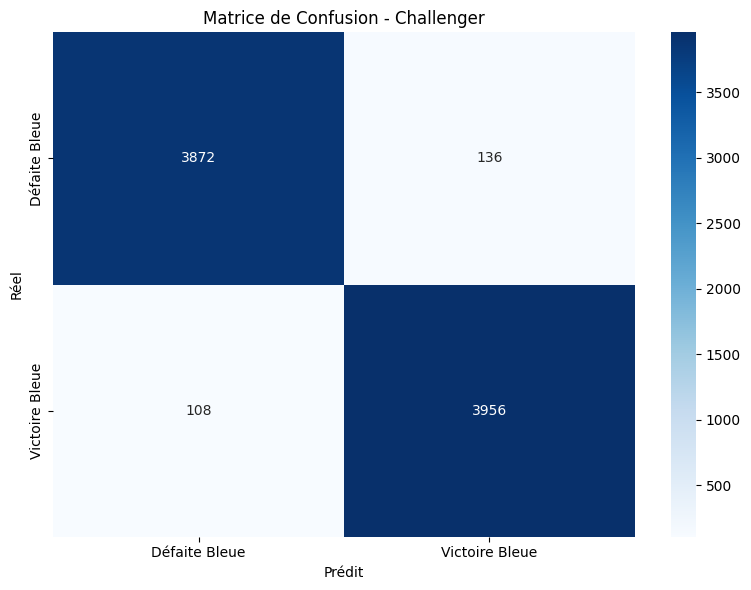

Importance des features sauvegardée: 'feature_importance_Challenger.png'


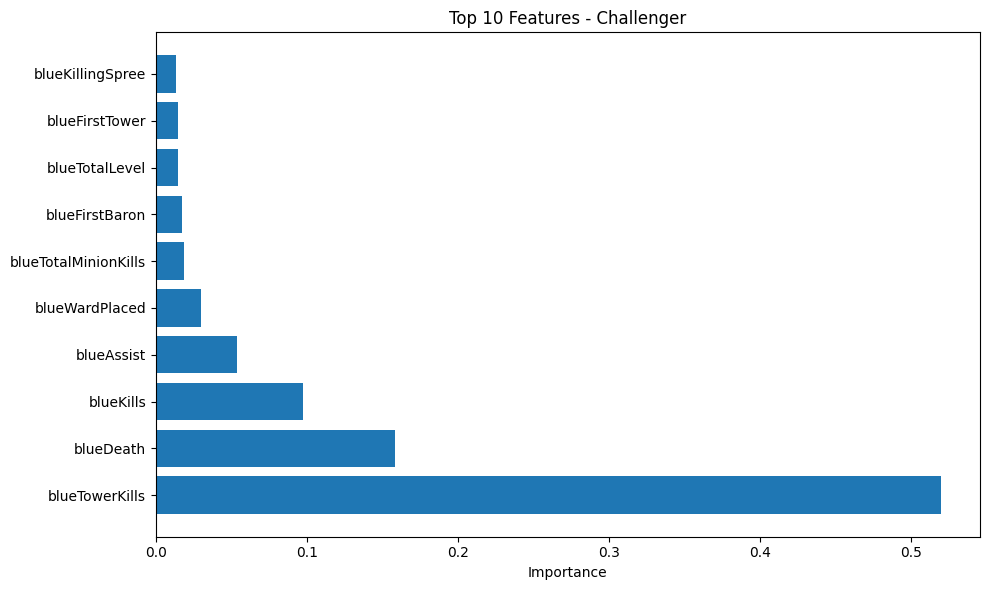

Distribution des probabilités sauvegardée: 'probability_distribution_Challenger.png'


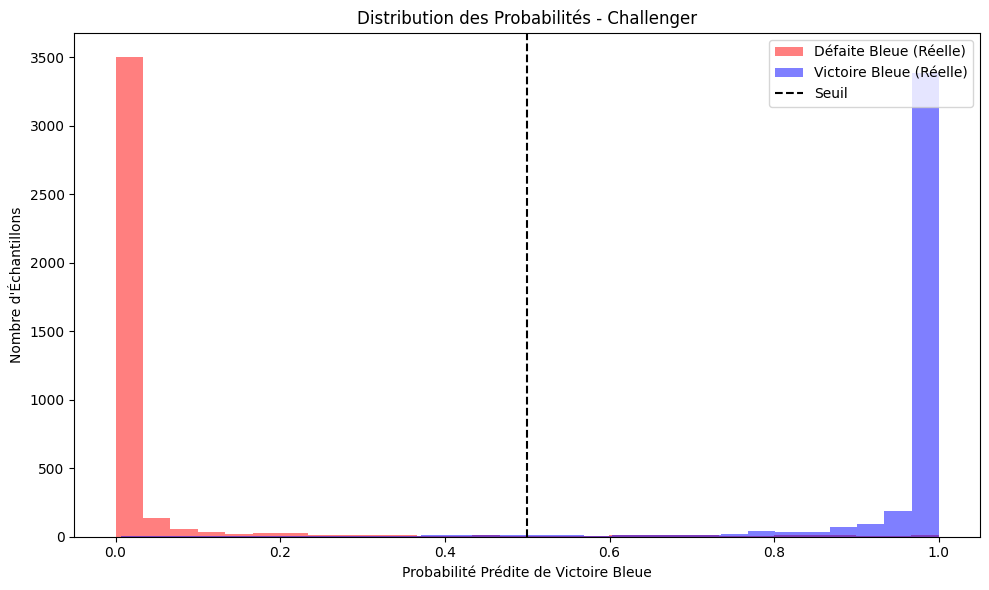



===== Analyse du niveau GrandMaster =====

===== Entraînement pour GrandMaster =====
Paramètres: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.9702
F1 Score: 0.9702

===== Évaluation pour GrandMaster =====
Accuracy: 0.9702
ROC AUC: 0.9959
F1 Score: 0.9702

Rapport de classification:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9948
           1       0.96      0.98      0.97      9821

    accuracy                           0.97     19769
   macro avg       0.97      0.97      0.97     19769
weighted avg       0.97      0.97      0.97     19769

Matrice de confusion sauvegardée: 'confusion_matrix_GrandMaster.png'


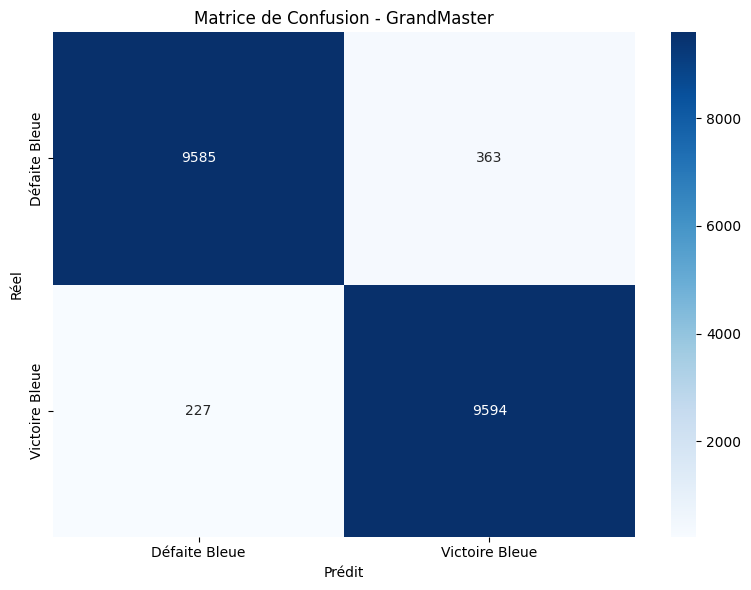

Importance des features sauvegardée: 'feature_importance_GrandMaster.png'


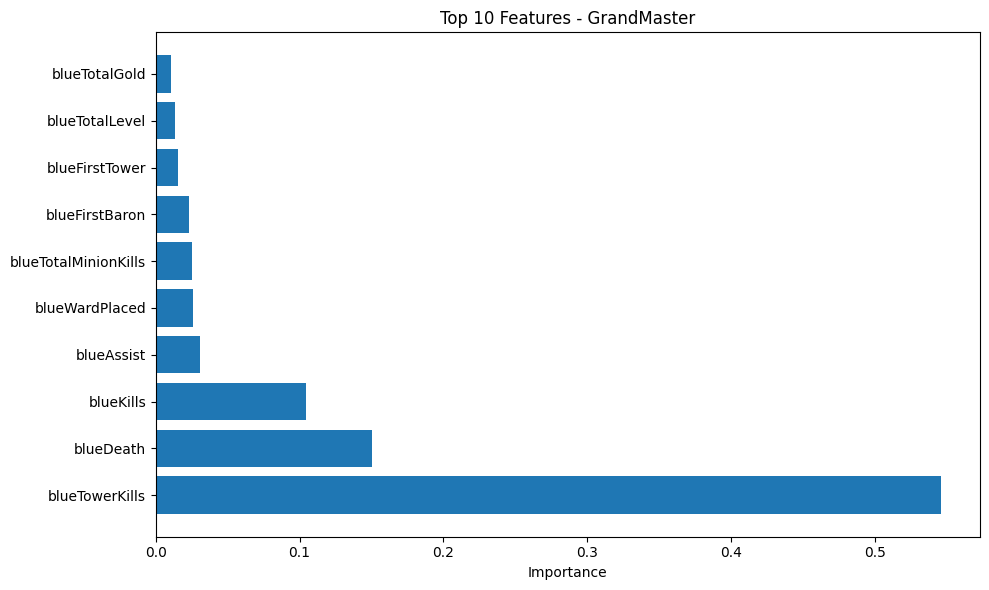

Distribution des probabilités sauvegardée: 'probability_distribution_GrandMaster.png'


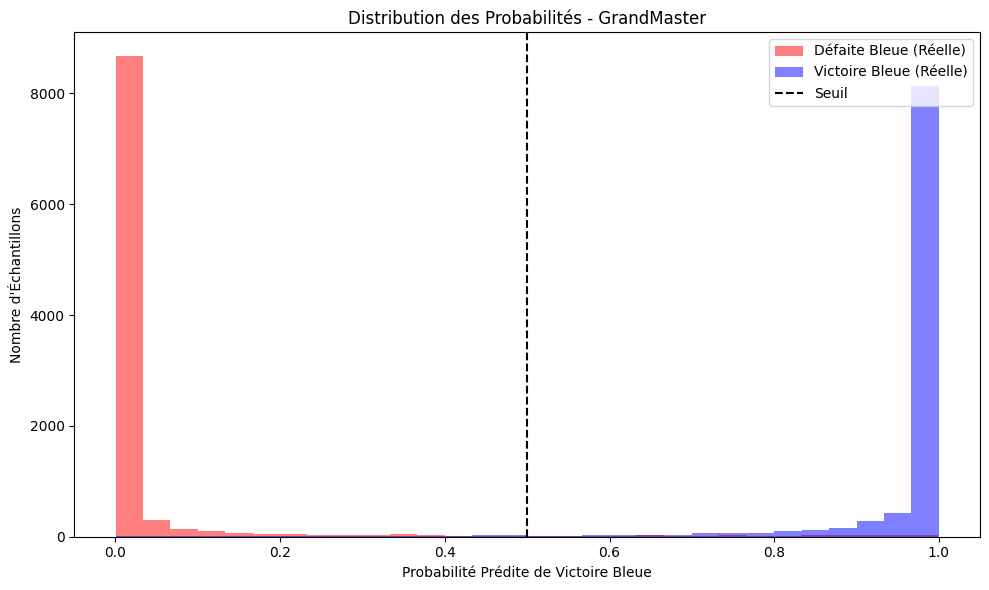



===== Analyse du niveau Master =====

===== Entraînement pour Master =====
Paramètres: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.9700
F1 Score: 0.9697

===== Évaluation pour Master =====
Accuracy: 0.9700
ROC AUC: 0.9961
F1 Score: 0.9697

Rapport de classification:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     16300
           1       0.96      0.98      0.97     15838

    accuracy                           0.97     32138
   macro avg       0.97      0.97      0.97     32138
weighted avg       0.97      0.97      0.97     32138

Matrice de confusion sauvegardée: 'confusion_matrix_Master.png'


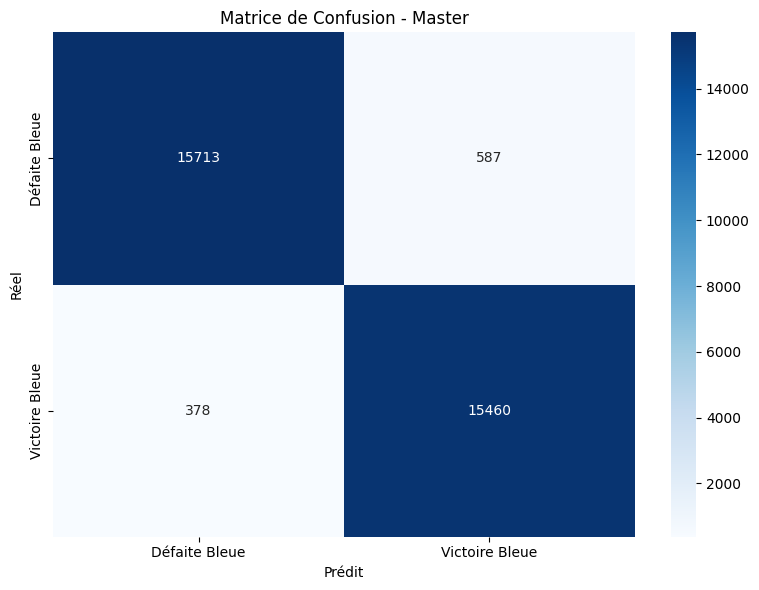

Importance des features sauvegardée: 'feature_importance_Master.png'


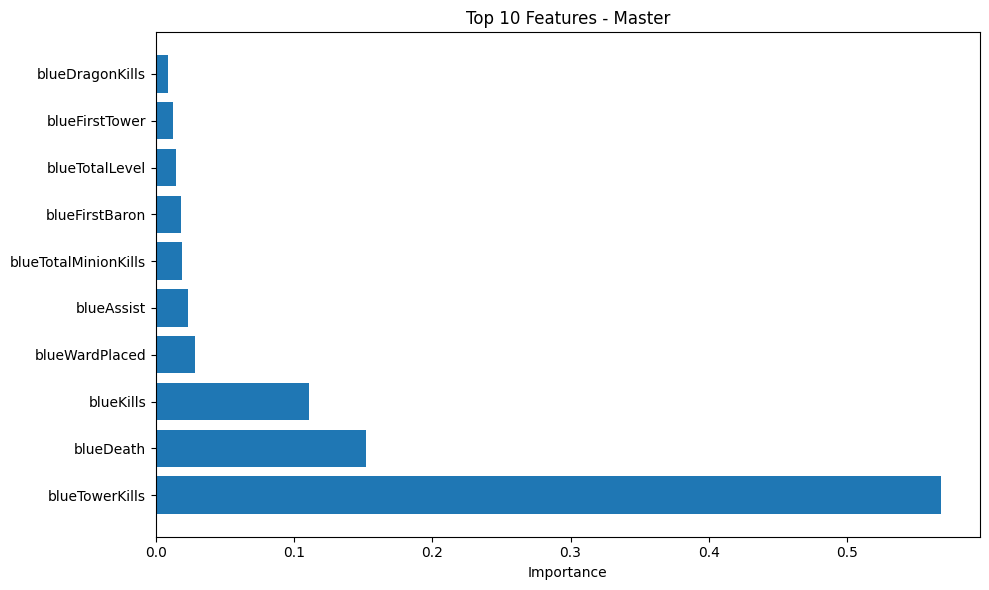

Distribution des probabilités sauvegardée: 'probability_distribution_Master.png'


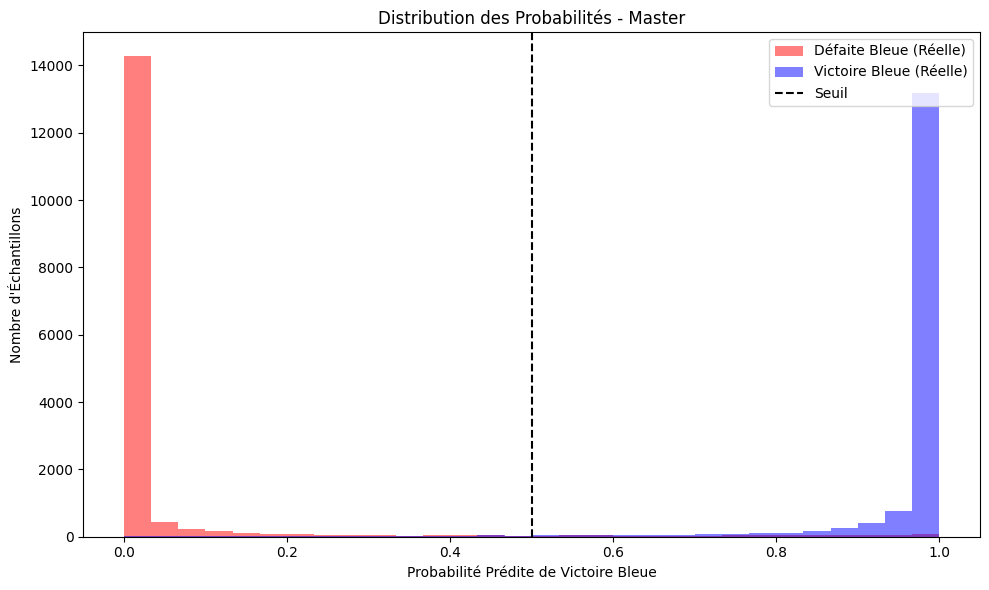


===== Comparaison des niveaux =====

Comparaison des performances:
        Niveau  Accuracy   ROC AUC  F1 Score
0   Challenger  0.969772  0.996673  0.970083
1  GrandMaster  0.970155  0.995871  0.970169
2       Master  0.969973  0.996060  0.969735
Comparaison des performances sauvegardée: 'performance_comparison.png'


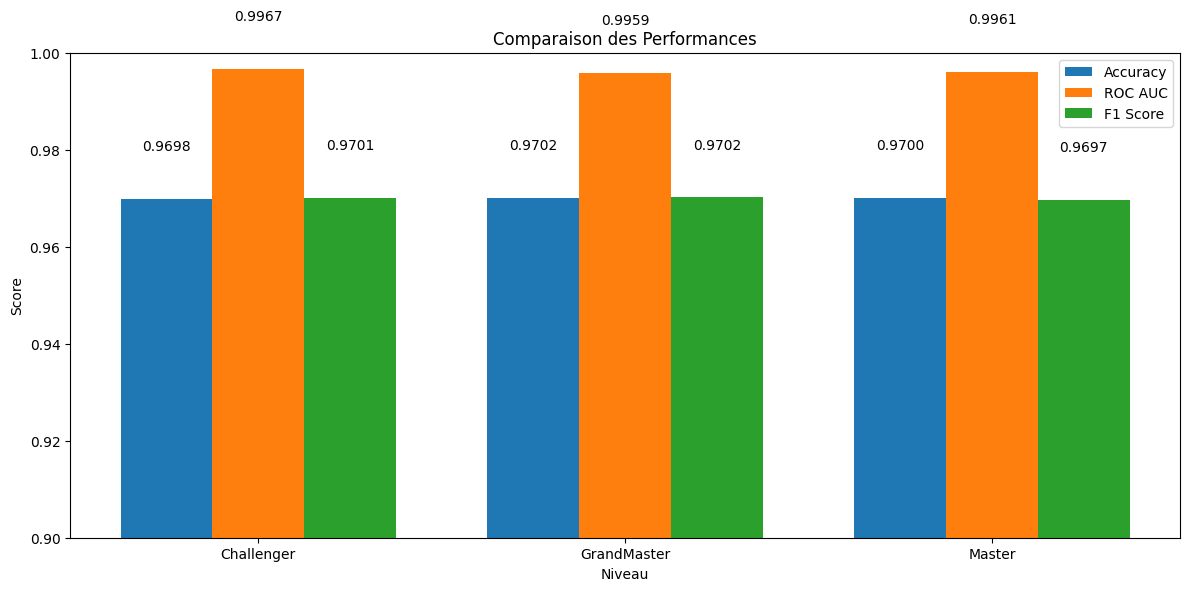


===== Features importantes par niveau =====

Top 5 features pour Challenger:
          Feature  Importance
5  blueTowerKills    0.519883
8       blueDeath    0.158651
7       blueKills    0.097330
9      blueAssist    0.053499
6  blueWardPlaced    0.029663

Top 5 features pour GrandMaster:
          Feature  Importance
5  blueTowerKills    0.546036
8       blueDeath    0.150527
7       blueKills    0.104210
9      blueAssist    0.030517
6  blueWardPlaced    0.025749

Top 5 features pour Master:
          Feature  Importance
5  blueTowerKills    0.567826
8       blueDeath    0.151909
7       blueKills    0.110730
6  blueWardPlaced    0.028277
9      blueAssist    0.023409

Top 10 features en moyenne:
                 Feature  Challenger  GrandMaster    Master   Average
0         blueTowerKills    0.519883     0.546036  0.567826  0.544581
1              blueDeath    0.158651     0.150527  0.151909  0.153696
2              blueKills    0.097330     0.104210  0.110730  0.104090
3         

<ipython-input-19-a446bd48e334>:217: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  feature_data.append(float(top5[top5['Feature'] == feature][level]))


Comparaison des features sauvegardée: 'feature_comparison.png'


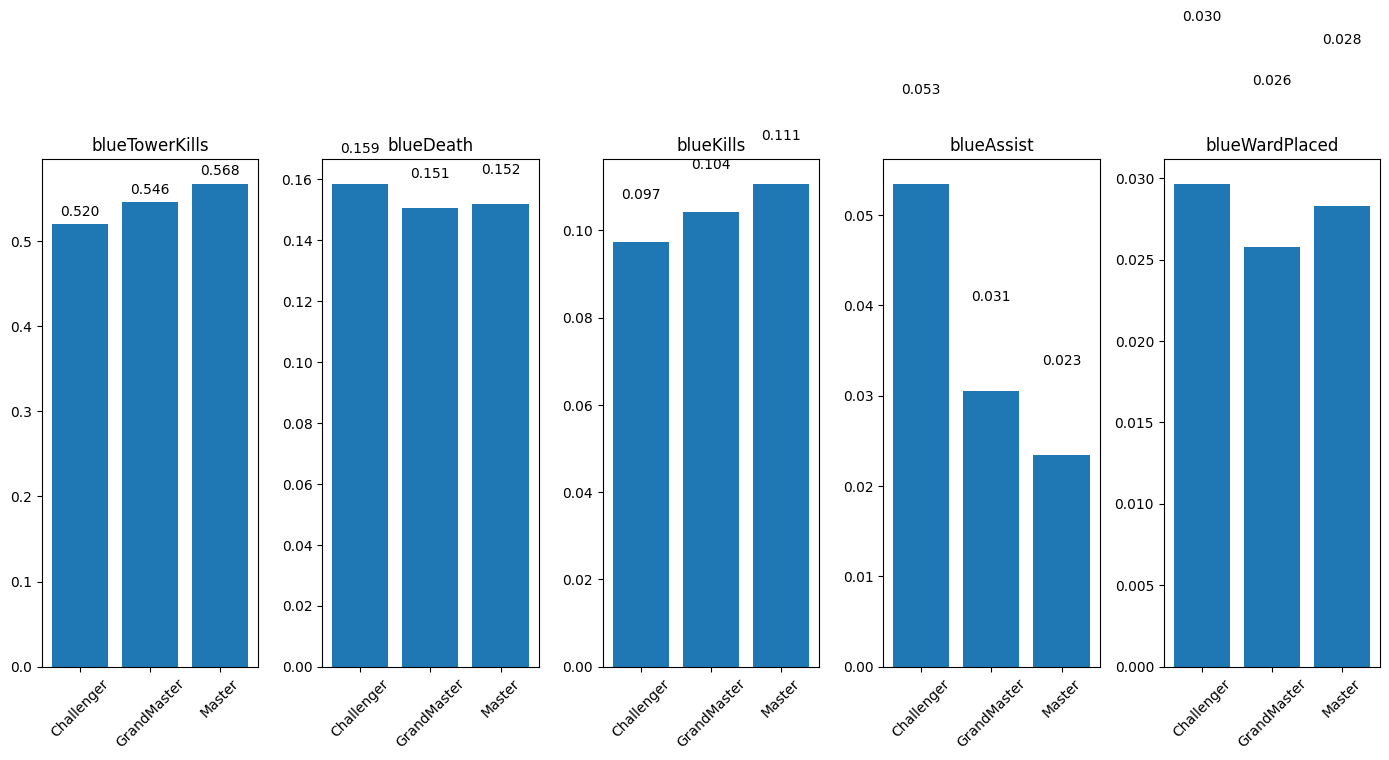


===== Analyse terminée =====
Tous les graphiques ont été sauvegardés.


In [19]:
def train_xgboost_with_params(X_train, y_train, X_test, y_test, level_name, params):
    """
    Entraîne le modèle avec les meilleurs paramètres connus
    """
    print(f"\n===== Entraînement pour {level_name} =====")
    print(f"Paramètres: {params}")

    # Création du modèle
    model = xgb.XGBClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        random_state=42
    )

    # Entraînement
    model.fit(X_train, y_train)

    # Évaluation rapide
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return model, accuracy, f1

def evaluate_xgboost(model, X_test, y_test, level_name, feature_names):
    """
    Évalue le modèle et génère les graphiques
    """
    print(f"\n===== Évaluation pour {level_name} =====")

    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Rapport détaillé
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Graphiques
    # 1. Matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Défaite Bleue', 'Victoire Bleue'],
                yticklabels=['Défaite Bleue', 'Victoire Bleue'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - {level_name}')
    plt.tight_layout()

    plt.savefig(f'confusion_matrix_{level_name}.png')
    print(f"Matrice de confusion sauvegardée: 'confusion_matrix_{level_name}.png'")
    plt.show()
    plt.close()

    # 2. Importance des features
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    top_indices = indices[:10]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_indices)), importance[top_indices], align='center')
    plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Features - {level_name}')
    plt.tight_layout()

    plt.savefig(f'feature_importance_{level_name}.png')
    print(f"Importance des features sauvegardée: 'feature_importance_{level_name}.png'")
    plt.show()
    plt.close()

    # 3. Distribution des probabilités
    plt.figure(figsize=(10, 6))

    # Séparation par classe réelle
    proba_class0 = y_pred_proba[y_test == 0]  # Défaite bleue
    proba_class1 = y_pred_proba[y_test == 1]  # Victoire bleue

    plt.hist(proba_class0, bins=30, alpha=0.5, label='Défaite Bleue (Réelle)', color='red')
    plt.hist(proba_class1, bins=30, alpha=0.5, label='Victoire Bleue (Réelle)', color='blue')

    plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil')
    plt.xlabel('Probabilité Prédite de Victoire Bleue')
    plt.ylabel('Nombre d\'Échantillons')
    plt.title(f'Distribution des Probabilités - {level_name}')
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'probability_distribution_{level_name}.png')
    print(f"Distribution des probabilités sauvegardée: 'probability_distribution_{level_name}.png'")
    plt.show()
    plt.close()

    return accuracy, roc_auc, f1

def compare_levels(results, feature_names):
    """
    Compare les performances entre niveaux
    """
    print("\n===== Comparaison des niveaux =====")

    # Récupération des données
    levels = list(results.keys())
    accuracies = [results[level]['accuracy'] for level in levels]
    roc_aucs = [results[level]['roc_auc'] for level in levels]
    f1_scores = [results[level]['f1_score'] for level in levels]

    # Tableau comparatif
    comparison_df = pd.DataFrame({
        'Niveau': levels,
        'Accuracy': accuracies,
        'ROC AUC': roc_aucs,
        'F1 Score': f1_scores
    })

    print("\nComparaison des performances:")
    print(comparison_df)

    # Graphique de comparaison
    plt.figure(figsize=(12, 6))

    x = np.arange(len(levels))
    width = 0.25

    plt.bar(x - width, accuracies, width, label='Accuracy')
    plt.bar(x, roc_aucs, width, label='ROC AUC')
    plt.bar(x + width, f1_scores, width, label='F1 Score')

    plt.xlabel('Niveau')
    plt.ylabel('Score')
    plt.title('Comparaison des Performances')
    plt.xticks(x, levels)
    plt.legend()

    # Valeurs sur les barres
    for i, v in enumerate(accuracies):
        plt.text(i - width, v + 0.01, f'{v:.4f}', ha='center')

    for i, v in enumerate(roc_aucs):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    for i, v in enumerate(f1_scores):
        plt.text(i + width, v + 0.01, f'{v:.4f}', ha='center')

    plt.ylim(0.9, 1.0)  # Ajustement pour visibilité
    plt.tight_layout()

    plt.savefig('performance_comparison.png')
    print("Comparaison des performances sauvegardée: 'performance_comparison.png'")
    plt.show()
    plt.close()

    # Features importantes par niveau
    print("\n===== Features importantes par niveau =====")

    # Récupération des importances
    all_importances_list = []

    for level, data in results.items():
        model = data['model']
        importance = model.feature_importances_

        # DataFrame avec noms de features
        imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Top 5 features
        print(f"\nTop 5 features pour {level}:")
        print(imp_df.head(5))

        # Préparation pour comparaison
        level_imp = imp_df.copy()
        level_imp.columns = ['Feature', level]
        all_importances_list.append(level_imp)

    # Fusion des données
    all_importances = all_importances_list[0]
    for i in range(1, len(all_importances_list)):
        all_importances = pd.merge(all_importances, all_importances_list[i], on='Feature')

    # Ajout de la moyenne
    all_importances['Average'] = all_importances.iloc[:, 1:].mean(axis=1)
    all_importances = all_importances.sort_values('Average', ascending=False)

    print("\nTop 10 features en moyenne:")
    print(all_importances.head(10))

    # Graphique comparatif
    top5 = all_importances.head(5)

    plt.figure(figsize=(14, 8))

    for i, feature in enumerate(top5['Feature'].values):
        plt.subplot(1, 5, i+1)
        feature_data = []
        for level in levels:
            feature_data.append(float(top5[top5['Feature'] == feature][level]))

        plt.bar(levels, feature_data)
        plt.title(feature)
        plt.xticks(rotation=45)

        # Affichage des valeurs
        for j, v in enumerate(feature_data):
            plt.text(j, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig('feature_comparison.png')
    print("Comparaison des features sauvegardée: 'feature_comparison.png'")
    plt.show()
    plt.close()

    return comparison_df, all_importances

def main():
    """
    Fonction principale
    """
    # Liste des features pour l'affichage
    feature_names = [
        'blueFirstBlood', 'blueFirstTower', 'blueFirstBaron', 'blueFirstDragon',
        'blueDragonKills', 'blueTowerKills', 'blueWardPlaced', 'blueKills',
        'blueDeath', 'blueAssist', 'blueChampionDamageDealt', 'blueTotalGold',
        'blueTotalMinionKills', 'blueTotalLevel', 'blueKillingSpree',
        'blueTotalHeal', 'blueObjectDamageDealt'
    ]

    # Meilleurs paramètres trouvés
    best_params = {
        'Challenger': {
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 3,
            'n_estimators': 300,
            'subsample': 0.9
        },
        'GrandMaster': {
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 1,
            'n_estimators': 300,
            'subsample': 0.8
        },
        'Master': {
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_weight': 1,
            'n_estimators': 200,
            'subsample': 0.8
        }
    }

    # Données par niveau
    data_sets = {
        'Challenger': (X_train_challenger, X_test_challenger, y_train_challenger, y_test_challenger),
        'GrandMaster': (X_train_grandmaster, X_test_grandmaster, y_train_grandmaster, y_test_grandmaster),
        'Master': (X_train_master, X_test_master, y_train_master, y_test_master)
    }

    print("Données chargées.")

    # Stockage des résultats
    results = {}

    # Analyse par niveau
    for level_name, (X_train, X_test, y_train, y_test) in data_sets.items():
        print(f"\n\n===== Analyse du niveau {level_name} =====")

        # Entraînement avec paramètres optimaux
        best_model, accuracy, f1 = train_xgboost_with_params(
            X_train, y_train, X_test, y_test, level_name,
            best_params[level_name]
        )

        # Évaluation complète
        accuracy, roc_auc, f1_score = evaluate_xgboost(
            best_model, X_test, y_test, level_name, feature_names
        )

        # Sauvegarde des résultats
        results[level_name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'f1_score': f1_score,
            'best_params': best_params[level_name],
            'model': best_model
        }

    # Comparaison finale
    compare_levels(results, feature_names)

    print("\n===== Analyse terminée =====")
    print("Tous les graphiques ont été sauvegardés.")

if __name__ == "__main__":
    main()

# Analyse de l'avantage par côté (bleu vs rouge)


===== Analyse de l'avantage par côté =====

----- Niveau Challenger -----
Taux de victoire équipe bleue: 0.5001 ± 0.0060
Taille de l'échantillon: 26904
Test binomial (p-value): 0.9854
Résultat: Pas d'avantage significatif

----- Niveau GrandMaster -----
Taux de victoire équipe bleue: 0.4956 ± 0.0038
Taille de l'échantillon: 65896
Test binomial (p-value): 0.0246
Résultat: Avantage statistiquement significatif pour l'équipe ROUGE

----- Niveau Master -----
Taux de victoire équipe bleue: 0.4951 ± 0.0030
Taille de l'échantillon: 107125
Test binomial (p-value): 0.0015
Résultat: Avantage statistiquement significatif pour l'équipe ROUGE


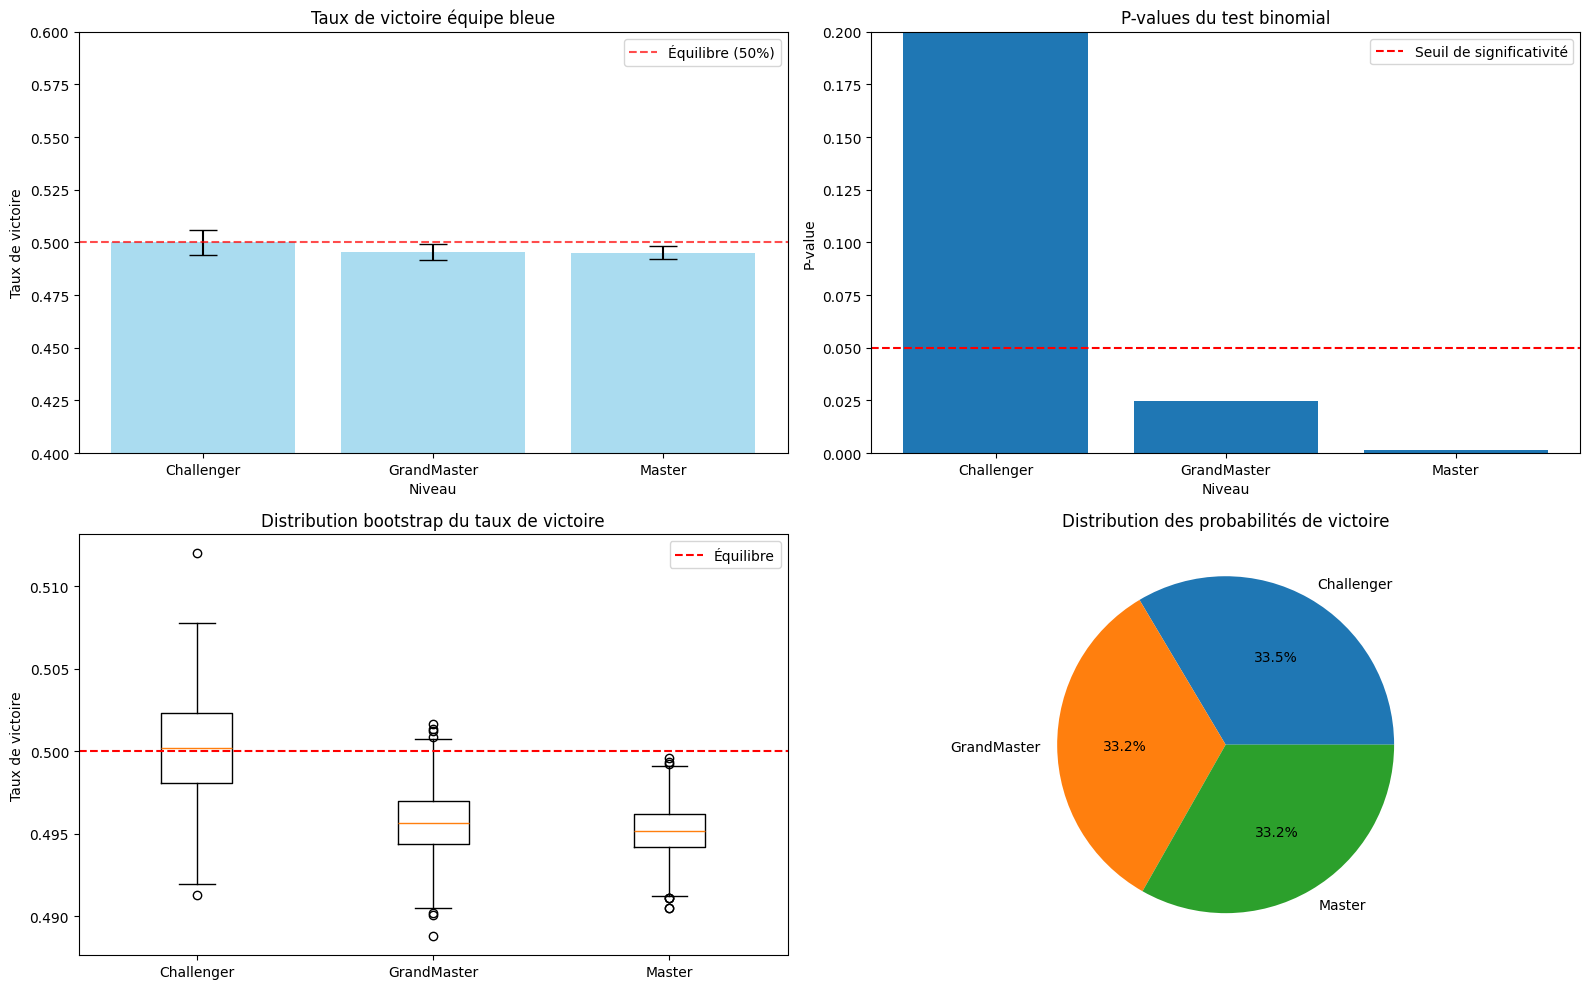

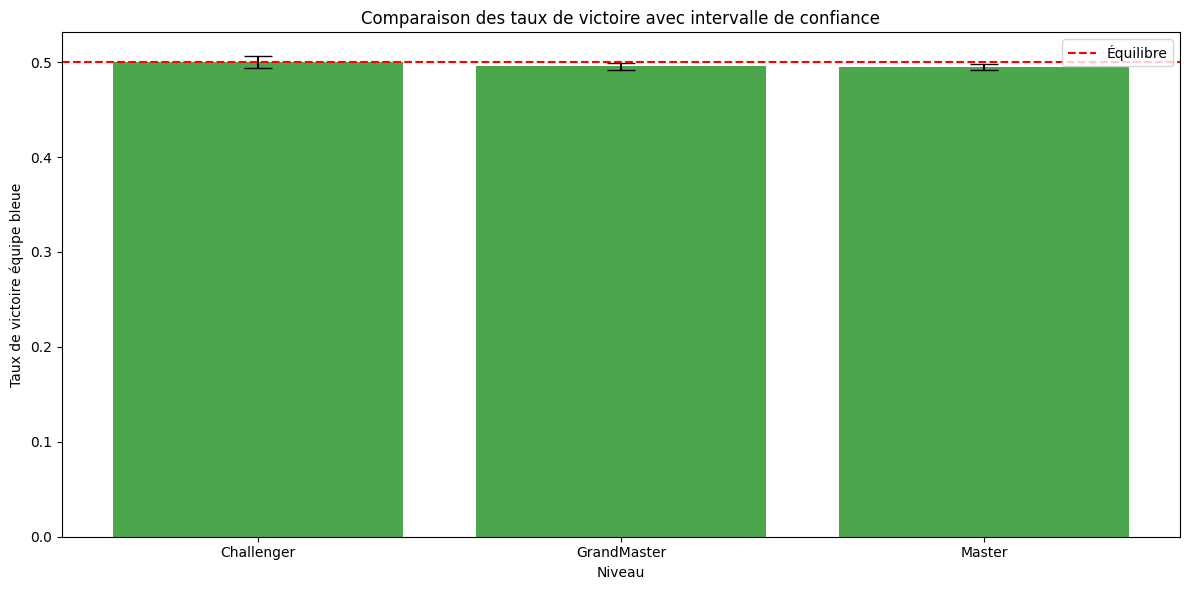


===== Tests statistiques complémentaires =====

----- Niveau Challenger -----
Test du chi-2:
Statistique: 0.0006, p-value: 0.9805
Test exact de Fisher:
Rapport de cotes: 0.9997, p-value: 0.9931

----- Niveau GrandMaster -----
Test du chi-2:
Statistique: 5.0699, p-value: 0.0243
Test exact de Fisher:
Rapport de cotes: 1.0177, p-value: 0.1126

----- Niveau Master -----
Test du chi-2:
Statistique: 10.1549, p-value: 0.0014
Test exact de Fisher:
Rapport de cotes: 1.0197, p-value: 0.0244


In [20]:
def analyze_side_advantage(data_sets):
    print("\n===== Analyse de l'avantage par côté =====")

    results = {}
    visualization_data = []

    for level_name, (X_train, X_test, y_train, y_test) in data_sets.items():
        y_all = np.concatenate([y_train, y_test])

        blue_win_rate = np.mean(y_all)
        n = len(y_all)
        std_err = np.sqrt((blue_win_rate * (1 - blue_win_rate)) / n)
        ci_95 = 1.96 * std_err

        successes = np.sum(y_all)
        p_value = 2 * min(
            stats.binom.cdf(successes, n, 0.5),
            1 - stats.binom.cdf(successes - 1, n, 0.5)
        )

        results[level_name] = {
            'Blue win rate': blue_win_rate,
            'Confidence interval (95%)': ci_95,
            'Sample size': n,
            'p-value': p_value
        }

        visualization_data.append({
            'Level': level_name,
            'Blue win rate': blue_win_rate,
            'Confidence interval': ci_95,
            'p-value': p_value
        })

        print(f"\n----- Niveau {level_name} -----")
        print(f"Taux de victoire équipe bleue: {blue_win_rate:.4f} ± {ci_95:.4f}")
        print(f"Taille de l'échantillon: {n}")
        print(f"Test binomial (p-value): {p_value:.4f}")

        if p_value < 0.05:
            if blue_win_rate > 0.5:
                print("Résultat: Avantage statistiquement significatif pour l'équipe BLEUE")
            else:
                print("Résultat: Avantage statistiquement significatif pour l'équipe ROUGE")
        else:
            print("Résultat: Pas d'avantage significatif")

    # Visualisation avec plusieurs graphiques
    plt.figure(figsize=(16, 10))

    # Taux de victoire
    plt.subplot(2, 2, 1)
    df_results = pd.DataFrame(visualization_data)

    x = np.arange(len(df_results))
    plt.bar(x, df_results['Blue win rate'],
            yerr=df_results['Confidence interval'],
            capsize=10, color='skyblue', alpha=0.7)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label="Équilibre (50%)")
    plt.title('Taux de victoire équipe bleue')
    plt.xlabel('Niveau')
    plt.ylabel('Taux de victoire')
    plt.xticks(x, df_results['Level'])
    plt.ylim(0.4, 0.6)
    plt.legend()

    # P-value
    plt.subplot(2, 2, 2)
    plt.bar(df_results['Level'], df_results['p-value'])
    plt.title('P-values du test binomial')
    plt.xlabel('Niveau')
    plt.ylabel('P-value')
    plt.axhline(y=0.05, color='red', linestyle='--', label='Seuil de significativité')
    plt.ylim(0, 0.2)
    plt.legend()

    # Distribution Bootstrap
    plt.subplot(2, 2, 3)
    boxplot_data = []
    for level_name, (X_train, X_test, y_train, y_test) in data_sets.items():
        y_all = np.concatenate([y_train, y_test])
        bootstraps = [np.mean(np.random.choice(y_all, size=len(y_all), replace=True))
                      for _ in range(1000)]
        boxplot_data.append(bootstraps)

    plt.boxplot(boxplot_data, tick_labels=list(data_sets.keys()))
    plt.title('Distribution bootstrap du taux de victoire')
    plt.ylabel('Taux de victoire')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Équilibre')
    plt.legend()

    # Diagramme circulaire
    plt.subplot(2, 2, 4)
    probabilities = [results[level]['Blue win rate'] for level in results]
    plt.pie(probabilities, labels=list(results.keys()), autopct='%1.1f%%')
    plt.title('Distribution des probabilités de victoire')

    plt.tight_layout()
    plt.show()

    # Graphique style Seaborn
    plt.figure(figsize=(12, 6))
    plt.title('Comparaison des taux de victoire avec intervalle de confiance')

    # Barres d'erreur
    x = np.arange(len(df_results))
    plt.bar(x, df_results['Blue win rate'],
            yerr=df_results['Confidence interval'],
            capsize=10, color='green', alpha=0.7)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Équilibre')
    plt.xlabel('Niveau')
    plt.ylabel('Taux de victoire équipe bleue')
    plt.xticks(x, df_results['Level'])
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

def additional_statistical_tests(data_sets):
    print("\n===== Tests statistiques complémentaires =====")

    results = {}

    for level_name, (X_train, X_test, y_train, y_test) in data_sets.items():
        y_all = np.concatenate([y_train, y_test])

        # Test du chi-2
        obs_freq = [np.sum(y_all == 0), np.sum(y_all == 1)]
        chi2, p_chi2 = stats.chisquare(obs_freq)

        # Test exact de Fisher
        fisher_oddsr, fisher_p = stats.fisher_exact([obs_freq, [len(y_all)//2, len(y_all)//2]])

        results[level_name] = {
            'Chi-square': {
                'statistic': chi2,
                'p-value': p_chi2
            },
            'Fisher exact': {
                'odds ratio': fisher_oddsr,
                'p-value': fisher_p
            }
        }

        print(f"\n----- Niveau {level_name} -----")
        print("Test du chi-2:")
        print(f"Statistique: {chi2:.4f}, p-value: {p_chi2:.4f}")
        print("Test exact de Fisher:")
        print(f"Rapport de cotes: {fisher_oddsr:.4f}, p-value: {fisher_p:.4f}")

    return results

def run_analysis(data_sets):
    side_advantage_results = analyze_side_advantage(data_sets)
    additional_tests = additional_statistical_tests(data_sets)

    return side_advantage_results, additional_tests

if __name__ == "__main__":
    # Utilisation - à remplacer par vos données
    data_sets = {
        'Challenger': (X_train_challenger, X_test_challenger, y_train_challenger, y_test_challenger),
        'GrandMaster': (X_train_grandmaster, X_test_grandmaster, y_train_grandmaster, y_test_grandmaster),
        'Master': (X_train_master, X_test_master, y_train_master, y_test_master)
    }

    run_analysis(data_sets)